In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, max_error, mean_absolute_error
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, LeaveOneOut, StratifiedKFold, cross_val_score, learning_curve, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import random
import glob
import os


import warnings
warnings.filterwarnings('ignore')

In [2]:
laser = pd.read_csv("./laserTargets.csv", header=None)
laser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 10093 entries, 0 to 10092
dtypes: int64(10093)
memory usage: 79.0 KB


In [3]:
laser = laser.transpose()
laser.reset_index(drop=True, inplace=True)
laser.columns = ['Values']
laser.head()

,Values
0,86
1,141
2,95
3,41
4,22


In [4]:
laser.describe()

,Values
count,10093.000000
mean,59.831566
std,47.050893
min,0.000000
25%,23.000000
50%,46.000000
75%,84.000000
max,255.000000


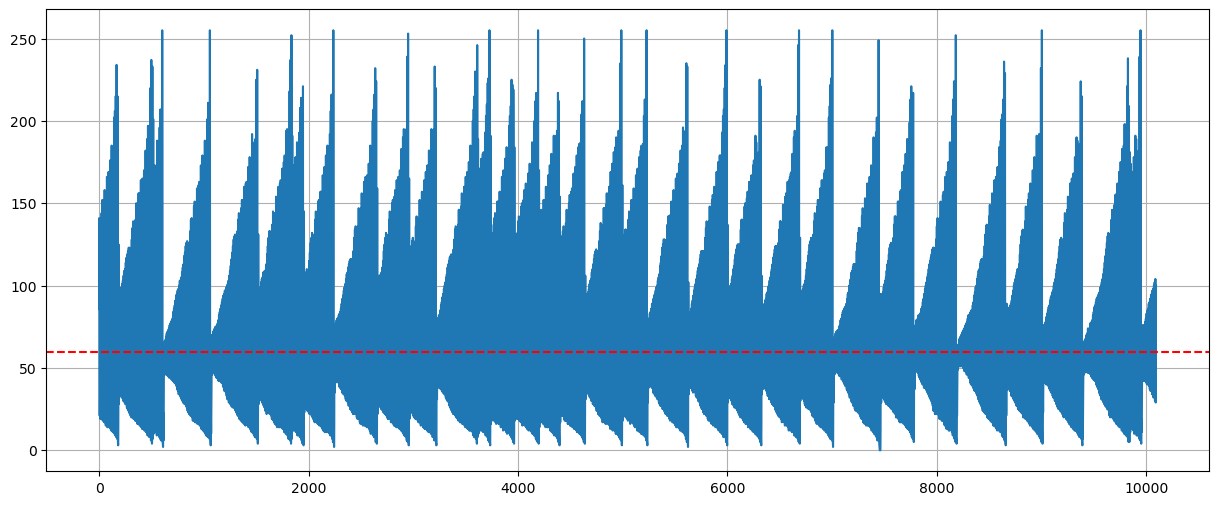

In [5]:
mean_value = np.mean(laser['Values'])

plt.figure(figsize=(15, 6))
laser['Values'].plot()
plt.axhline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.grid(True)

In [6]:
scaler = StandardScaler()

In [13]:
X = laser.index.values.reshape(-1, 1)
y = laser['Values']

In [15]:
X

array([[    0],
       [    1],
       [    2],
       ...,
       [10090],
       [10091],
       [10092]])

In [17]:
y

0         86
1        141
2         95
3         41
4         22
        ... 
10088     37
10089     29
10090     35
10091     60
10092    100
Name: Values, Length: 10093, dtype: int64

In [19]:
def build_nn_model(input_dim):
    model = Sequential()

    # Input Layer
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Hidden Layer 1
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Hidden Layer 2
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Hidden Layer 3
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Hidden Layer 4
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    # Output Layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

    return model

Elastic_net scores:
   r2: -0.0019
   mean_squared_error: 2214.6776
   root_mean_squared_error: 47.0418
   max_error: 191.9017
   mean_absolute_error: 37.4528


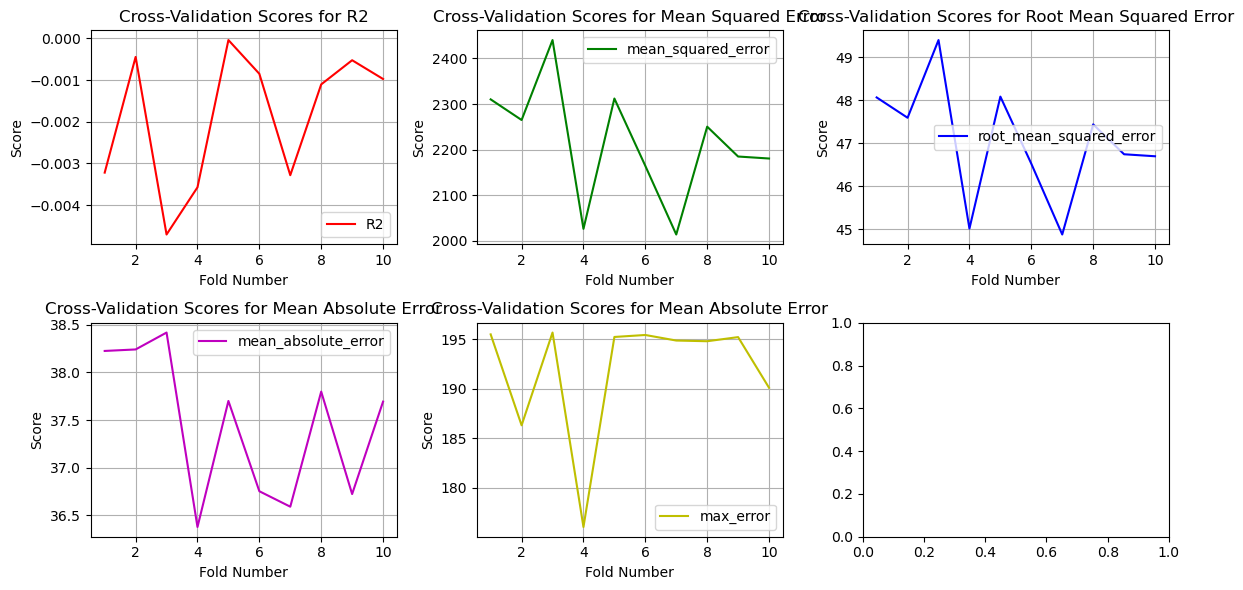

Overall R2 score on full dataset:  -2.9334012708881474e-05


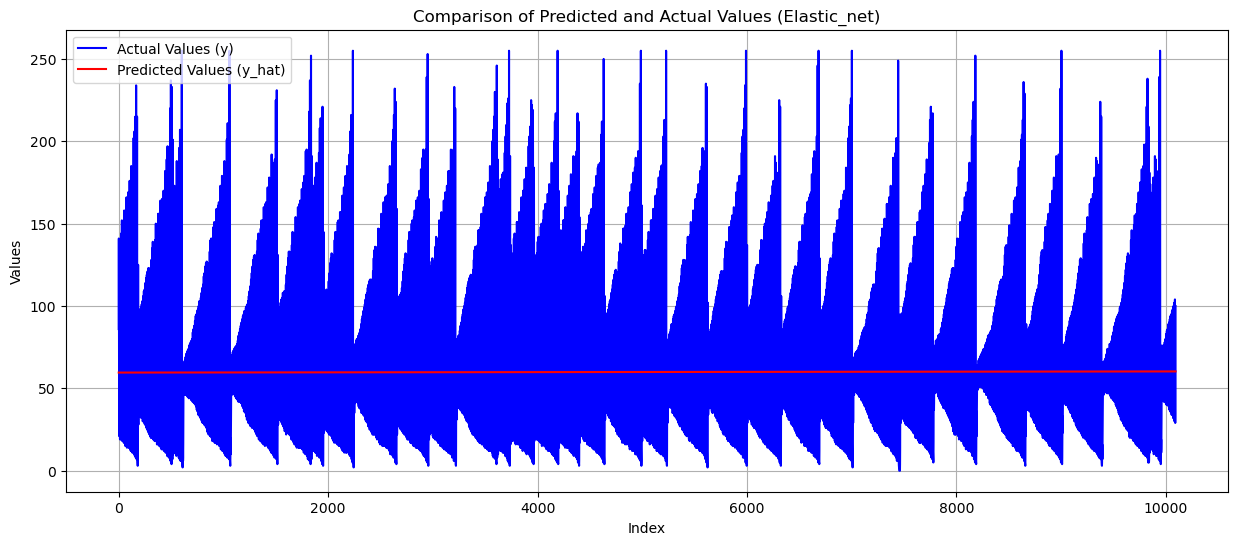

Random_forest scores:
   r2: 0.3619
   mean_squared_error: 1410.8265
   root_mean_squared_error: 37.5470
   max_error: 179.7580
   mean_absolute_error: 26.3224


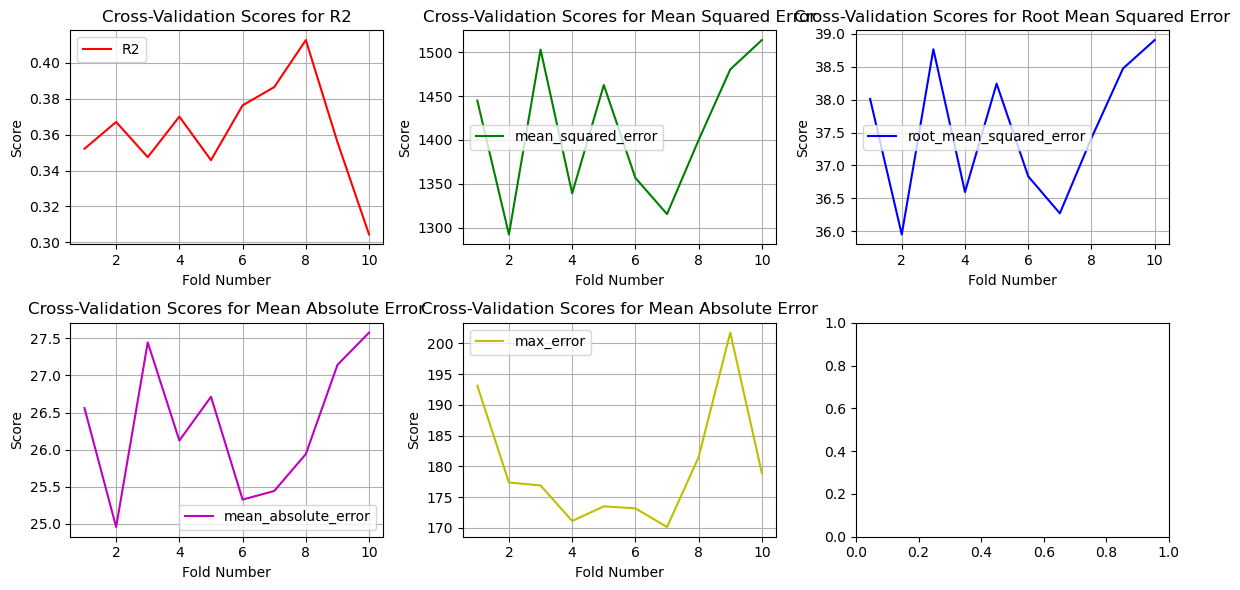

Overall R2 score on full dataset:  0.8511979819489568


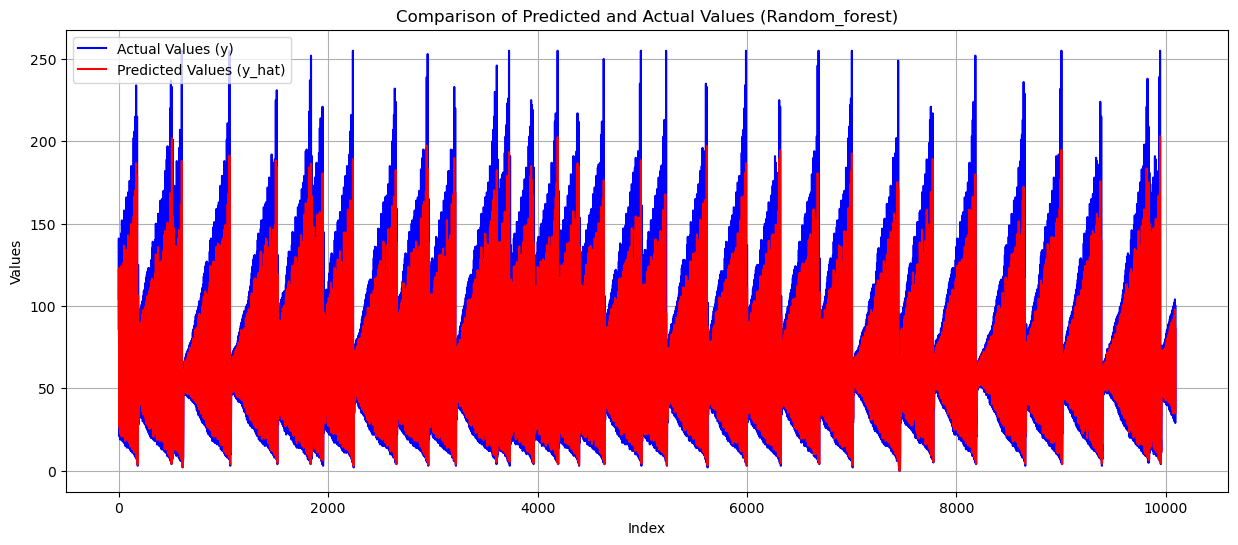

Neural network scores:
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
   r2: -0.0032
   mean_squared_error: 2219.0885
   root_mean_squared_error: 47.0960
   max_error: 191.7482
   mean_absolute_error: 37.2448
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step


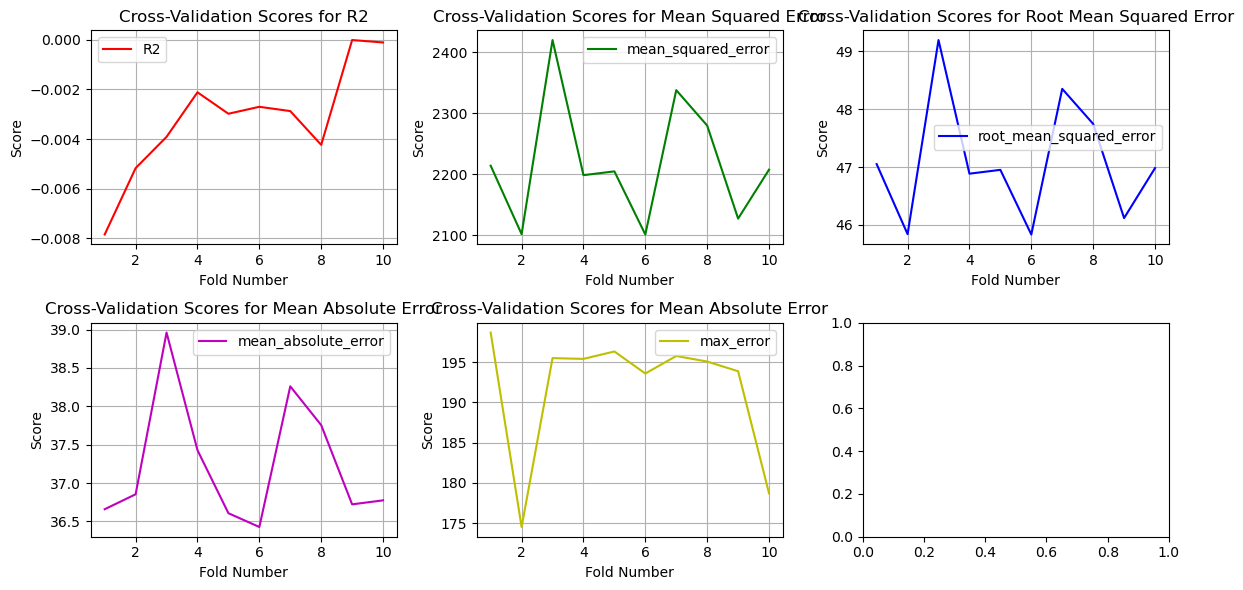

Overall R2 score on full dataset:  -0.003516325506804474


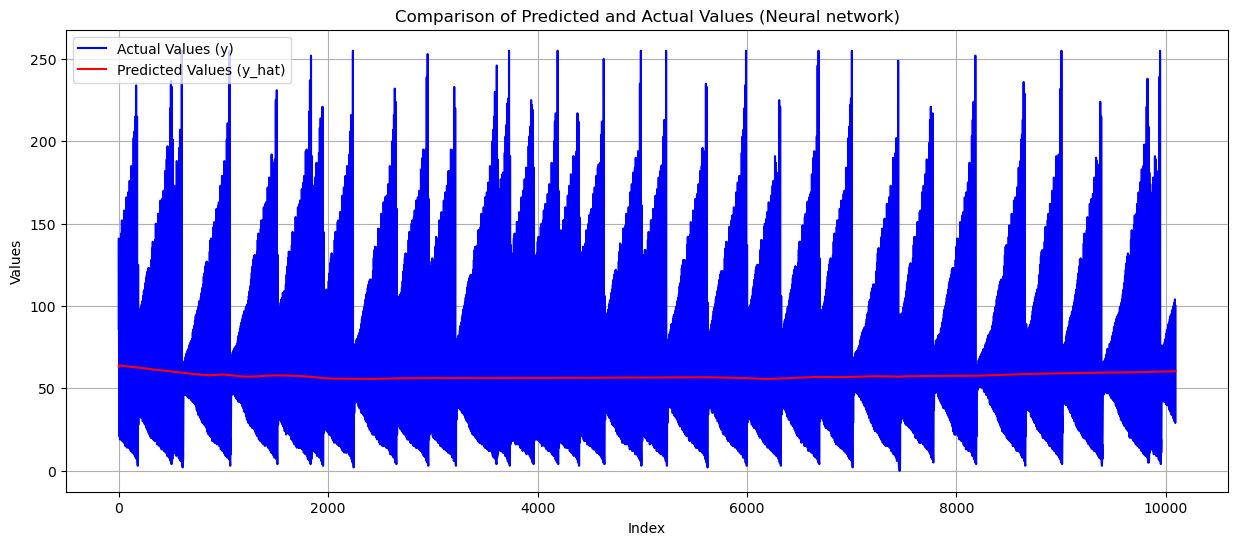

In [20]:
scores = ['r2', 'mean_squared_error', 'root_mean_squared_error', 'max_error', 'mean_absolute_error']
cv = KFold(n_splits=10, shuffle=True)

# Define regressors
regressors = {
    "Elastic_net": ElasticNet(alpha=0.4),
    "Random_forest": RandomForestRegressor(),
    "Neural network": "Keras"
}

# Iterate through each regressor
for regressor_name, model in regressors.items():
    print(f'{regressor_name} scores:')
    
    # Initialize storage for metric results
    metric_results = {score: [] for score in scores}
    fold_models = []  # Reset fold models for each regressor

    # Perform manual KFold cross-validation
    for train_idx, test_idx in cv.split(X):
        # Split the data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Handle Keras model separately to create a fresh instance each time
        if model == "Keras":
            keras_model = build_nn_model(input_dim=X_train.shape[1])
            keras_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
            y_pred = keras_model.predict(X_test).flatten()  # Flatten to 1D array
            fold_models.append(keras_model)
        else:
            # For scikit-learn models
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            fold_models.append(model)

        # Calculate and store each metric manually
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        max_err = max_error(y_test, y_pred)

        # Store the scores (negate where necessary to match cross_val_score convention)
        metric_results['r2'].append(r2)
        metric_results['mean_squared_error'].append(mse)
        metric_results['root_mean_squared_error'].append(rmse)
        metric_results['mean_absolute_error'].append(mae)
        metric_results['max_error'].append(max_err)

    # Display average scores
    for score in scores:
        mean_score = np.mean(metric_results[score])
        print(f'   {score}: {mean_score:.4f}')

    # Select a random model from this regressor's folds
    random_model = random.choice(fold_models)
    if regressor_name == "Neural Network (Keras)":
        y_hat = random_model.predict(X).flatten()
    else:
        y_hat = random_model.predict(X)
    
    # Plot cross-validation scores
    fig, ax = plt.subplots(2, 3, figsize=(12, 6))

    # Plotting only R2 in the second subplot
    ax[0,0].plot(
        range(1, len(metric_results['r2']) + 1),
        metric_results['r2'],
        label='R2',
        color='r'
    )
    ax[0,0].set_title("Cross-Validation Scores for R2")
    ax[0,0].set_xlabel("Fold Number")
    ax[0,0].set_ylabel("Score")
    ax[0,0].legend(loc="best")
    ax[0,0].grid(True)
    
    ax[0,1].plot(
        range(1, len(metric_results['mean_squared_error']) + 1),
        metric_results['mean_squared_error'],
        label='mean_squared_error',
        color='g'
    )
    ax[0,1].set_title("Cross-Validation Scores for Mean Squared Error")
    ax[0,1].set_xlabel("Fold Number")
    ax[0,1].set_ylabel("Score")
    ax[0,1].legend(loc="best")
    ax[0,1].grid(True)

    ax[0,2].plot(
        range(1, len(metric_results['mean_squared_error']) + 1),
        metric_results['root_mean_squared_error'],
        label='root_mean_squared_error',
        color='b'
    )
    ax[0,2].set_title("Cross-Validation Scores for Root Mean Squared Error")
    ax[0,2].set_xlabel("Fold Number")
    ax[0,2].set_ylabel("Score")
    ax[0,2].legend(loc="best")
    ax[0,2].grid(True)

    ax[1,0].plot(
        range(1, len(metric_results['mean_absolute_error']) + 1),
        metric_results['mean_absolute_error'],
        label='mean_absolute_error',
        color='m'
    )
    ax[1,0].set_title("Cross-Validation Scores for Mean Absolute Error")
    ax[1,0].set_xlabel("Fold Number")
    ax[1,0].set_ylabel("Score")
    ax[1,0].legend(loc="best")
    ax[1,0].grid(True)

    ax[1,1].plot(
        range(1, len(metric_results['max_error']) + 1),
        metric_results['max_error'],
        label='max_error',
        color='y'
    )
    ax[1,1].set_title("Cross-Validation Scores for Mean Absolute Error")
    ax[1,1].set_xlabel("Fold Number")
    ax[1,1].set_ylabel("Score")
    ax[1,1].legend(loc="best")
    ax[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

    # Plot predicted vs actual values
    plt.figure(figsize=(15, 6))
    plt.plot(y, color='b', label='Actual Values (y)')
    plt.plot(y_hat, color='r', label='Predicted Values (y_hat)')
    
    # Adding labels and grid
    print("Overall R2 score on full dataset: ", r2_score(y, y_hat))
    plt.title(f"Comparison of Predicted and Actual Values ({regressor_name})")
    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()
